In [1]:
import pandas as pd
import numpy as np
import librosa
import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot

In [2]:
# se usa del GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

In [3]:
# se lee el dataframe
#df = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
#df.head()

In [4]:
def grab_sound_features(filename):
    sample_rate = 12000
    duration = 3

    # Cargamos el audio
    X, sample_rate = librosa.load(filename, sr=sample_rate, res_type='kaiser_fast')
    n_sample = X.shape[0]
    n_sample_fit = int(duration*sample_rate)

    # Si el audio es muy grande, limitamos la duracion del audio.
    # Si es menor se completa con ceros.
    if n_sample < n_sample_fit:
        X = np.hstack((X, np.zeros((n_sample_fit - n_sample,))))
    elif n_sample > n_sample_fit:
        X = X[int((n_sample-n_sample_fit)/2):int((n_sample+n_sample_fit)/2)]
    
    return librosa.feature.melspectrogram(y=X, sr=sample_rate)

def parser():
    feature = []
    label = []
    # Funcion para cargar archivos y extraer caracteristicas
    for filename in glob.glob("data/scream/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(1)
    for filename in glob.glob("data/no-scream/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(0)
    return [feature, label]

In [5]:
data = np.array(parser()).transpose()
n = data.shape[0]

/home/percykim/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/percykim/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/percykim/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [6]:
data[0,0].shape

(128, 71)

In [7]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([n, data[0,0].shape[0], data[0,0].shape[1]])

(166,) (166,)


In [8]:
for i in range(n):
    X[i] = (X_[i])

In [9]:
Y = to_categorical(Y)

In [10]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(166, 128, 71)
(166, 2)


In [11]:
# se conforman los conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [12]:
# se ajusta el tamaño de los sets
#X_train = X_train.reshape(X_train.shape[0], 16, 8, 1)
#X_test = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [13]:
#input_dim = (16, 8, 1)

In [14]:
input_dim = (X_train.shape[1], X_train.shape[2])

In [15]:
# Crea el modelo en tensorflow keras
model = Sequential()

# Definimos un modelo LSTM many to one
model.add(LSTM(units=256, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_dim))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

W0705 12:32:39.859974 140576622987072 deprecation.py:506] From /home/percykim/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 256)          335872    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 594,882
Trainable params: 594,882
Non-trainable params: 0
_________________________________________________________________


In [16]:
# se entrena el modelo en 90 epocas y batch size de 50
#model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 50, validation_data = (X_test, Y_test))

W0705 12:32:41.906971 140576622987072 deprecation.py:323] From /home/percykim/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 124 samples, validate on 42 samples
Epoch 1/50
124/124 [==============================] - 15s 120ms/sample - loss: 0.6682 - acc: 0.5000 - val_loss: 0.6178 - val_acc: 0.7381
Epoch 2/50
124/124 [==============================] - 8s 62ms/sample - loss: 0.5924 - acc: 0.7177 - val_loss: 0.5670 - val_acc: 0.7381
Epoch 3/50
124/124 [==============================] - 8s 62ms/sample - loss: 0.4980 - acc: 0.8226 - val_loss: 0.4610 - val_acc: 0.7857
Epoch 4/50
124/124 [==============================] - 8s 61ms/sample - loss: 0.4100 - acc: 0.8790 - val_loss: 0.3806 - val_acc: 0.8571
Epoch 5/50
124/124 [==============================] - 8s 60ms/sample - loss: 0.2982 - acc: 0.9032 - val_loss: 0.2989 - val_acc: 0.9048
Epoch 6/50
124/124 [==============================] - 8s 61ms/sample - loss: 0.2607 - acc: 0.9194 - val_loss: 0.3366 - val_acc: 0.8571
Epoch 7/50
124/124 [==============================] - 8s 61ms/sample - loss: 0.2805 - acc: 0.9113 - val_loss: 0.3384 - val_acc: 0.8810
Epoch 8/

In [17]:
# se muestra el accuracy final obtenido
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

42/42 [==============================] - 1s 18ms/sample - loss: 0.2208 - acc: 0.9524
[0.22076226380609332, 0.95238096]


In [18]:
# Guardar el Modelo
model.save('lstm.h5')

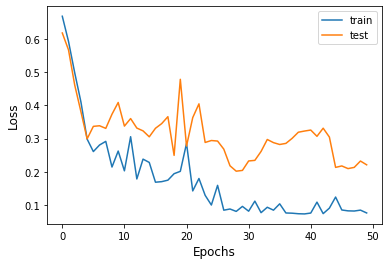

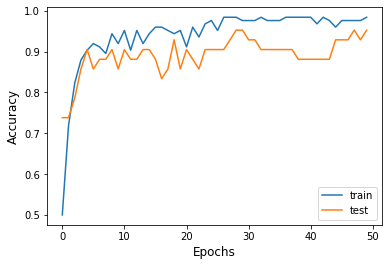

In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Loss', fontsize = 12)
pyplot.show()
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Accuracy', fontsize = 12)
pyplot.show()